<a href="https://colab.research.google.com/github/NickolosZH/rep1/blob/main/Colorectal%20cancer%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms

In [62]:
# Task 1: Tensormancy
# 1.1 The disclaimer

# Let's write another function, this time in polar coordinates:

# Then convert it into cartesian coordinates (howto) and plot the results.

# Use torch tensors only: no lists, loops, numpy arrays, etc.

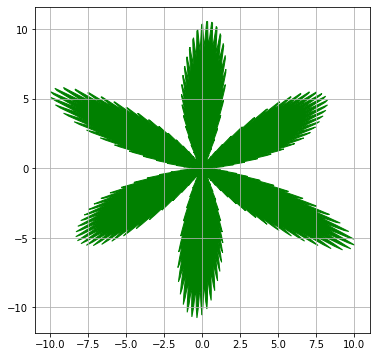

In [63]:
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + 0.9 * torch.cos(6 * theta)) \
    * (1 + 0.01 * torch.cos(24 * theta)) \
    * (0.5 + 0.05 * torch.cos(200 * theta)) \
    * (10 + torch.sin(10 * theta))  

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = torch.sin(theta) * rho
y = torch.cos(theta) * rho


plt.figure(figsize=(6, 6))
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

In [64]:
# Использование Датасета

In [65]:
from torch import nn
from torch.nn import functional as F

In [66]:
# Загружаем данные
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/master/week0_09_DL_step_2/notmnist.py -nc

File ‘notmnist.py’ already there; not retrieving.



In [67]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist()

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [68]:
X_train.shape

(14043, 1, 28, 28)

In [69]:
# Создаём класс Датасет
class DatasetMNIST(Dataset):
    def __init__(self, path='./notMNIST_small', letters='ABCDEFGHIJ', transform=None):
        self.data, self.labels, _ ,_  = load_notmnist(path=path, letters=letters, test_size=0)
        self.transform = transform  # Функция преобразований

    def __len__(self):  # Длина датасета
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data[index].transpose(1, 2, 0)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [70]:
full_dataset = DatasetMNIST('./notMNIST_small', 'AB', transform=None)  # Инициализируем класс DatasetMNIST (данные, метки, трансформации)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [71]:
# we can access and get data with index by __getitem__(index)
img, lab = full_dataset.__getitem__(0)  # Пример получения элемента датасета

print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [72]:
# torchvision позволяет делать преобразования "на лету"
a = torchvision.transforms.ToTensor()  # первое преобразование, самое важное - датасета в тензор

type(a(img))

torch.Tensor

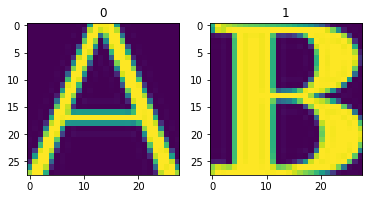

In [73]:
# Выводим 2 случайных элемента датасета
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28,28]))
    plt.title(str(full_dataset[inds[i]][1]))

In [74]:
# Используем DataLoader
train_loader = DataLoader(full_dataset, batch_size=8, shuffle=True) #, num_workers=0 - возможность распределить предобработку данных (отдать CPU) и вычисления (отдать GPU). Уменьшает время простоя GPU.

In [75]:
# Можно использовать DataLoader как итератор
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


In [76]:
images, labels = next(train_iter)

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size = torch.Size([8, 28, 28, 1])
labels shape on batch size = torch.Size([8])


/usr/local/lib/python3.9/dist-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


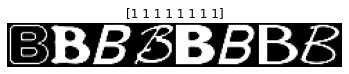

In [77]:
# make grid takes tensor as arg
# tensor : (batchsize, channels, height, width)
grid = torchvision.utils.make_grid(images.permute([0, 3, 1, 2]))

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

In [78]:
# Преобразуем Датасет в PyTorch Тензор
train_dataset_with_transform = DatasetMNIST(
    transform=torchvision.transforms.ToTensor()
)

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [79]:
# Получим первый элемент
img, lab = train_dataset_with_transform.__getitem__(0)

print('image shape at the first row : {}'.format(img.size()))

image shape at the first row : torch.Size([1, 28, 28])


In [80]:

train_loader_tr = DataLoader(train_dataset_with_transform, batch_size=8, shuffle=True)

train_iter_tr = iter(train_loader_tr)
print(type(train_iter_tr))

images, labels = next(train_iter_tr)

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


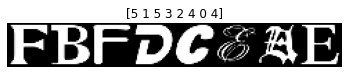

In [81]:
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

In [82]:
# Сочетание нескольких трансформаций

If you want to take data augmentation, you have to make List using torchvision.transforms.Compose

class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string
this function can convert some image by order within __call__ method.

In [83]:
# Пишем собственное преобразование. Для pytorch обязательно нужны методы __call__
# и __repr__
class Flatten():
    def __call__(self, pic):
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [84]:
a = Flatten()

In [85]:
a(img).shape

torch.Size([784])

In [86]:
# Функция Compose используется для сложных трансформаций

new_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # Преобразование в тензор
    Flatten()  # Представление тензора в виде одного вектора
])

# Соединяем всё вместе

In [87]:
import time

from IPython.display import clear_output

In [88]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [89]:
# Делаем функцию случайной выборки индексов из датасета
def subset_ind(dataset, ratio: float):  # Датасет, размер выборки
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

In [90]:
dataset = DatasetMNIST(
    './notMNIST_small',  # Путь
#     'AB', # Подписи
    transform=new_transform  # Преобразования
)

shrink_inds = subset_ind(dataset, 0.2)
dataset = Subset(dataset, shrink_inds)

print(f'\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}')

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


 dataset size: 3744, labels: [0 1 2 3 4 5 6 7 8 9]


In [91]:
# Теперь первый объект нашего датасета - это просто векто размера 784 или 28 * 28. Теперь не нужно волноваться, чтобы приводить данные к нужному формату.
dataset[0][0].shape

torch.Size([784])

In [92]:
val_size = 0.2  # Задаём размер обучающей выборки
val_inds = subset_ind(dataset, val_size)  # Получаем индексы обучающей выборки

train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])  # Формируем обучающий датасет
val_dataset = Subset(dataset, val_inds)

print(f'  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}')

  training size: 2996
validation size: 748


In [93]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [94]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = next(train_iter)

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([32, 784])
labels shape on batch size = torch.Size([32])


In [95]:
loss_func = nn.CrossEntropyLoss()

In [114]:
# Создаём сеть.
# !! Функция активации встроена в вункцию потерь!!
model = nn.Sequential(
    nn.Linear(784, 10)
)
model.to(device, torch.float32)  # Правильный способ отправки модели на устройство

opt = torch.optim.Adam(model.parameters(), lr=1e-3)  # Выбираем оптимизатор, который позволит обучать модель

In [115]:
# Посмотрим модель
from torchsummary import summary

summary(model, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [120]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    """
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных,
    loss_fn: целевая метрика (которую будем оптимизировать),
    opt: оптимизатор (обновляет веса нейросети),
    n_epochs: кол-во эпох
    """
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # Включаем во время обучения Dropout и BatchNorm
        for X_batch, y_batch in train_loader:

            opt.zero_grad()  # Зануляем градиенты оптмизатора. По умолчанию в pytorch градиенты накапливаются и их необходимо занулять.

            # Отправляем данные на то устройство, где находится наша модель
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            ## Считаем predictions и loss
            predictions = model(X_batch)  # Предсказание
            loss = loss_fn(predictions, y_batch)  # Получаем loss с помощью функции потерь, подавая на вход то, что мы предсказали и правильный ответ

            loss.backward()  # Считаем градиенты
            opt.step()  # Сделать шаг оптимизатора и обновить все веса
             
            ep_train_loss.append(loss.item())  
            # Необходимо использовать метод item(), чтобы вытаскивать из тензора 
            # только скаляр, число, а не весь граф вычислений. Это позволяет 
            # сильно сократить использование памяти.

        model.train(False) # Выключаем во время теста Dropout и используем среднее для BatchNorm
        with torch.no_grad():  # Продолжай без вычисления градиентов
            for X_batch, y_batch in val_loader:
                # Отправляем данные на то устройство, где находится наша модель
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                ## Считаем predictions и loss
                predictions = model(X_batch)  # Предсказание
                loss = loss_fn(predictions, y_batch)  # Получаем loss с помощью функции потерь, подавая на вход то, что мы предсказали и правильный ответ

                ep_val_loss.append(loss.item())

                y_pred = predictions.max(1)[1].data
                ep_val_accuracy.append(np.mean( ( y_batch.cpu() == y_pred.cpu()).numpy() ) )

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [121]:
# Обучаем модель

n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.662s
	  training loss: 1.704353
	validation loss: 1.583737
	validation accuracy: 0.877
Epoch 2 of 30 took 0.615s
	  training loss: 1.572873
	validation loss: 1.567352
	validation accuracy: 0.889
Epoch 3 of 30 took 0.574s
	  training loss: 1.548981
	validation loss: 1.557514
	validation accuracy: 0.898
Epoch 4 of 30 took 0.598s
	  training loss: 1.534701
	validation loss: 1.555588
	validation accuracy: 0.893
Epoch 5 of 30 took 0.563s
	  training loss: 1.523465
	validation loss: 1.550825
	validation accuracy: 0.903
Epoch 6 of 30 took 0.603s
	  training loss: 1.519917
	validation loss: 1.555486
	validation accuracy: 0.899
Epoch 7 of 30 took 0.567s
	  training loss: 1.516013
	validation loss: 1.561533
	validation accuracy: 0.885
Epoch 8 of 30 took 0.613s
	  training loss: 1.509400
	validation loss: 1.543821
	validation accuracy: 0.906
Epoch 9 of 30 took 0.575s
	  training loss: 1.505991
	validation loss: 1.548192
	validation accuracy: 0.905
Epoch 10 of 30 took 0.573s
	

In [122]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

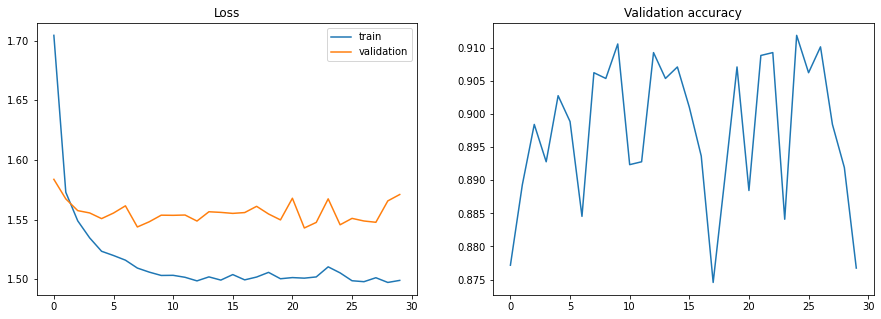

In [123]:
plot_train_process(train_loss, val_loss, val_accuracy)

# Реальная сеть

In [163]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 200),  # (кол-во входящих фичей, кол-во выходящих)
    nn.ReLU(),
    nn.Dropout(p=0.6),
    nn.BatchNorm1d(200),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Dropout(p=0.6),
    nn.Linear(100, 10)
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [164]:
summary(model, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
              ReLU-2                  [-1, 200]               0
           Dropout-3                  [-1, 200]               0
       BatchNorm1d-4                  [-1, 200]             400
            Linear-5                  [-1, 100]          20,100
              ReLU-6                  [-1, 100]               0
           Dropout-7                  [-1, 100]               0
            Linear-8                   [-1, 10]           1,010
Total params: 178,510
Trainable params: 178,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.68
Estimated Total Size (MB): 0.69
----------------------------------------------------------------


In [165]:
n_epochs = 40

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 40 took 0.328s
	  training loss: 1.572384
	validation loss: 0.732329
	validation accuracy: 0.851
Epoch 2 of 40 took 0.324s
	  training loss: 0.901027
	validation loss: 0.474179
	validation accuracy: 0.875
Epoch 3 of 40 took 0.303s
	  training loss: 0.732637
	validation loss: 0.426151
	validation accuracy: 0.886
Epoch 4 of 40 took 0.332s
	  training loss: 0.678933
	validation loss: 0.404382
	validation accuracy: 0.884
Epoch 5 of 40 took 0.340s
	  training loss: 0.637806
	validation loss: 0.377284
	validation accuracy: 0.896
Epoch 6 of 40 took 0.320s
	  training loss: 0.598236
	validation loss: 0.376366
	validation accuracy: 0.892
Epoch 7 of 40 took 0.369s
	  training loss: 0.579464
	validation loss: 0.358963
	validation accuracy: 0.904
Epoch 8 of 40 took 0.479s
	  training loss: 0.549305
	validation loss: 0.374538
	validation accuracy: 0.902
Epoch 9 of 40 took 0.467s
	  training loss: 0.548246
	validation loss: 0.388098
	validation accuracy: 0.899
Epoch 10 of 40 took 0.453s
	

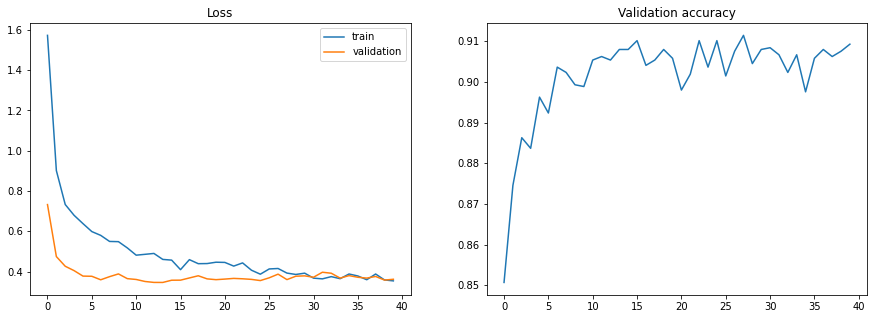

In [166]:
plot_train_process(train_loss, val_loss, val_accuracy)

# Сохранение модели

In [167]:
# Показать модель
model

Sequential(
  (0): Linear(in_features=784, out_features=200, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.6, inplace=False)
  (3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=200, out_features=100, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.6, inplace=False)
  (7): Linear(in_features=100, out_features=10, bias=True)
)

In [170]:
# Показать все параметры модели
# model.state_dict()

# Сохранить параметры модели
torch.save(model.state_dict(), 'my_checkpoint.pth')

In [181]:
## Пример загрузки весов обученной модели в необученную
# Создаём необученную модель
model2 = nn.Sequential(
    nn.Linear(784, 200),  # (кол-во входящих фичей, кол-во выходящих)
    nn.ReLU(),
    nn.Dropout(p=0.6),
    nn.BatchNorm1d(200),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Dropout(p=0.6),
    nn.Linear(100, 10)
)

In [182]:
model.eval()

Sequential(
  (0): Linear(in_features=784, out_features=200, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.6, inplace=False)
  (3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=200, out_features=100, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.6, inplace=False)
  (7): Linear(in_features=100, out_features=10, bias=True)
)

In [183]:
model2.eval()

Sequential(
  (0): Linear(in_features=784, out_features=200, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.6, inplace=False)
  (3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=200, out_features=100, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.6, inplace=False)
  (7): Linear(in_features=100, out_features=10, bias=True)
)

In [178]:
# Сравниваем 2 модели (обученную и необученную)
example_batch = next(iter(train_loader))
out = model2(example_batch[0])
torch.allclose(model(example_batch[0]), out)

False

In [185]:
# Загружаем сохранённые ранее веса обученной модели в необученную
model2.load_state_dict(torch.load('my_checkpoint.pth'))

<All keys matched successfully>

In [186]:
# Проверяем новую модель
out2 = model2(example_batch[0])
torch.allclose(model(example_batch[0]), out2)

True

In [ ]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [ ]:
# create a brand new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Testing -- you should get a pretty poor performance since the model hasn't learned anything yet.
test()

In [ ]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            # different from before: saving model checkpoints
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test()
    
    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

In [ ]:
train_save(5, save_interval=500, log_interval=100)

In [ ]:
!ls mnist*.pth

In [ ]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint('<CHECKPOINT NAME>', model, optimizer)
# should give you the final model accuracy
test()